In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine("sqlite:///./app/connection/test.db", echo=False)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
session = SessionLocal()

In [ ]:
# 가치 팩트(value fact)
"""
Ascending으로 정렬: 낮을수록 좋음
PER
PBR
PSR
PCR
DY
"""
# 퀄리티 팩트(quilty fact): 재무재표로 구함
"""
Descending으로 정렬: 높을수록 좋음
ROE
GPA
CFO
"""
# 모멘텀
"""
K-ratio
"""

In [2]:
from app.services.portfolio_services.multi_factor_portfolio_service import (
    MultiFactorPortfolioService,
)
from app.services.portfolio_services.multi_factor_portfolio_service import OutlierMethod

multi_factor_portfolio_service = MultiFactorPortfolioService(session)

In [ ]:
value_facts = ["PBR", "PCR", "PER", "PSR", "DY"]
quality_facts = ["ROE", "GPA", "CFO"]
momentum_facts = ["12M", "k_ratio"]
multi_factor_portfolio_service.set_facts(value_facts, quality_facts, momentum_facts)
rank20 = multi_factor_portfolio_service.get_final_rank(OutlierMethod.TRIM, 20)

In [3]:
value_facts = ["PBR", "PER"]
quality_facts = ["ROE"]
momentum_facts = ["k_ratio"]

multi_factor_portfolio_service.set_facts(value_facts, quality_facts, momentum_facts)
rank20_2 = multi_factor_portfolio_service.get_final_rank(OutlierMethod.TRIM, 20)

/Users/min/Documents/workspace/ai-stock-api/app/services/portfolio_services/momentum_portfolio_service.py:53: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = price_pivot.pct_change().iloc[1:]


In [ ]:
multi_factor_portfolio_service.paint_graph(rank20)

In [4]:
data_bind_final = multi_factor_portfolio_service._data_bind_final

data_bind = multi_factor_portfolio_service._data_bind

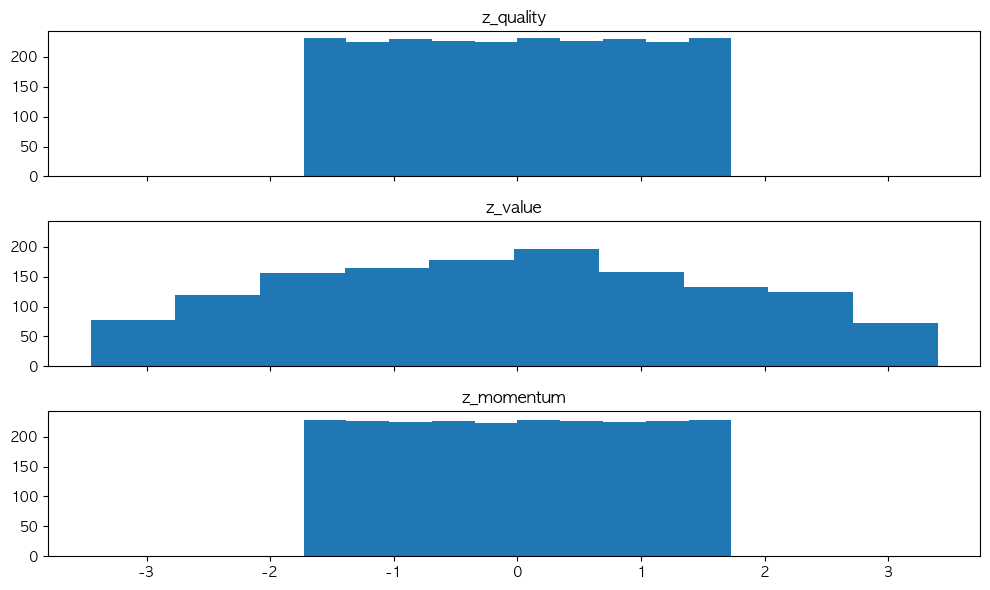

In [ ]:
multi_factor_portfolio_service.paint_graph(
    data_bind[["z_quality", "z_value", "z_momentum"]]
)